In [1]:
from mimic.utilities.utilities import *

from mimic.model_infer import *
from mimic.model_simulate import *
import random
import pandas as pd


import numpy as np


import matplotlib.pyplot as plt


import sklearn.linear_model


from scipy.integrate import odeint


from numpy import linalg as la


from sklearn.linear_model import LinearRegression


from sklearn.linear_model import Ridge


from sklearn.linear_model import Lasso


from sklearn.linear_model import ElasticNet, ElasticNetCV


from sklearn.model_selection import RepeatedKFold


from sklearn.model_selection import cross_val_score


from sklearn.model_selection import KFold


from sklearn.model_selection import GridSearchCV


import sys


sys.path.append("../../")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Simulate some time course data and perform ridge regression as in Stein et al. 2013
I have coded up the Stein model and ridge regression without the perturbation term (Ridge1) and with a single perturbation (Ridge 2). <br>
Ridge regression is designed to cause shrinkage to prevent overfitting. It isn't supposed to be used for variable
selection. We should use Lasso for this, however I think we need to constrain parameters.

### Five species, single time course

Model parameters:
Model: gMLV
num_species: 5
num_metabolites: 0
num_perturbations: 0
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
beta: None
epsilon: []
Using the following parameters for gMLV simulation: {'num_species': 5, 'num_metabolites': 0, 'num_perturbations': 0, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'beta': None, 'epsilon': array([], shape=(5, 0), dtype=float64)}
minimum found: a0/a1/error: 0.06951927961775606 0.0003359818286283781 0.10405332708603166
unconstrained error        : 0.10508759597522435
Using the following parameters for gMLV simu

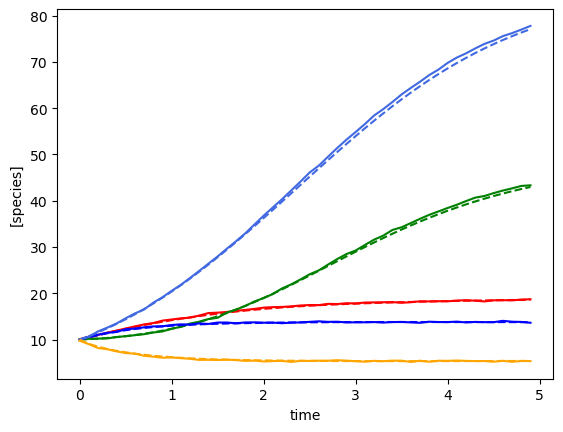

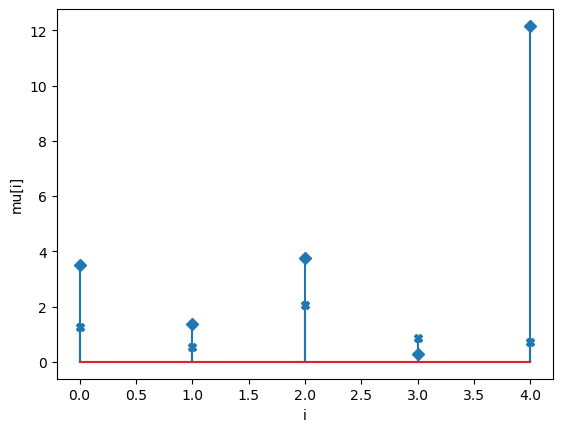

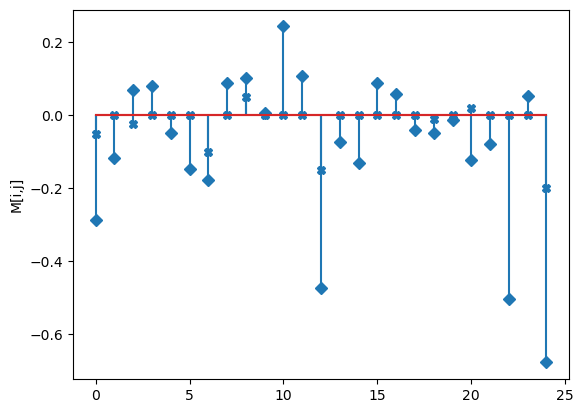

In [2]:
# In this example n >> p and it it is basically same as standard regression
# We have to be careful as most of these gLV models are very weakly identifiable

set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# instantiate simulator
simulator = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(
    times=times, sy0=np.hstack((init_species, init_metabolites)))

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
# plot_gLV(yobs, sobs, times)

# PERFORM REGRESSION
# linearise
X, F = linearize_time_course_16S(yobs, times)
# print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")

# get the best lambda/alpha values on a grid via cross validation
a0, a1 = fit_alpha_Ridge1(X, F, num_species=num_species, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = do_final_fit_Ridge1(X, F, num_species, a0, a1)
predictor = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(
    times=times, sy0=np.hstack((init_species, init_metabolites)))

# PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

### Five species, lower number of time points, multiple time course

Model parameters:
Model: gMLV
num_species: 5
num_metabolites: 0
num_perturbations: 0
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
beta: None
epsilon: []
Using the following parameters for gMLV simulation: {'num_species': 5, 'num_metabolites': 0, 'num_perturbations': 0, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'beta': None, 'epsilon': array([], shape=(5, 0), dtype=float64)}
Using the following parameters for gMLV simulation: {'num_species': 5, 'num_metabolites': 0, 'num_perturbations': 0, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.704

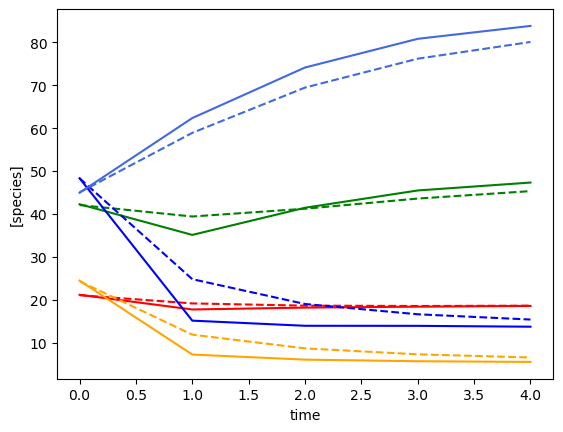

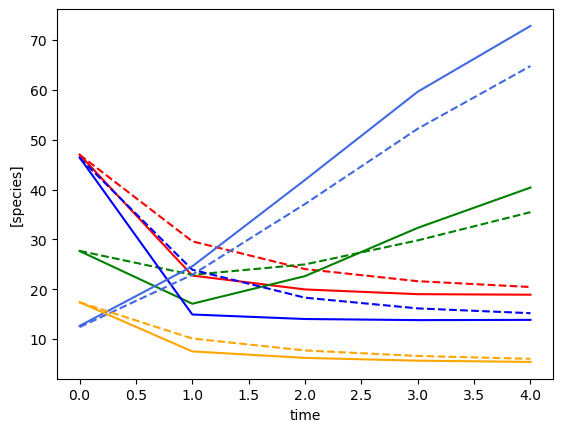

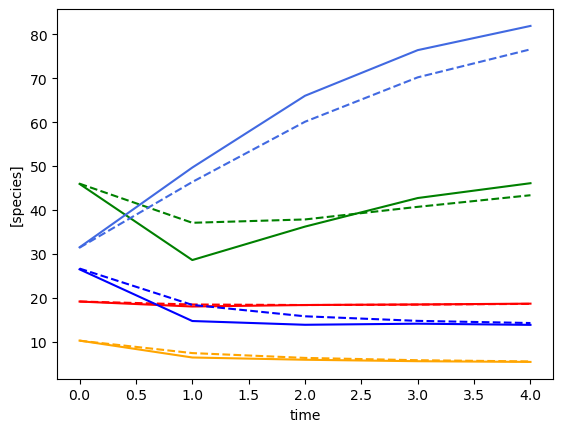

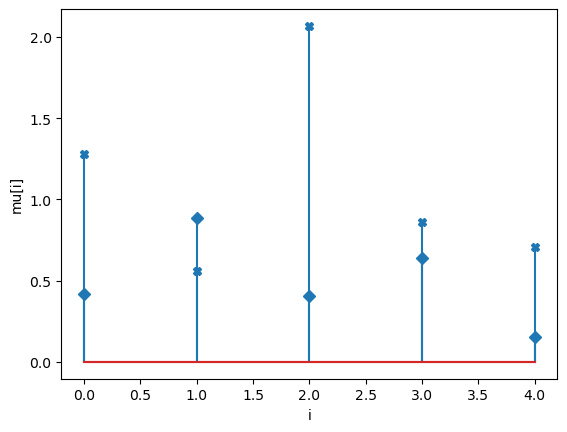

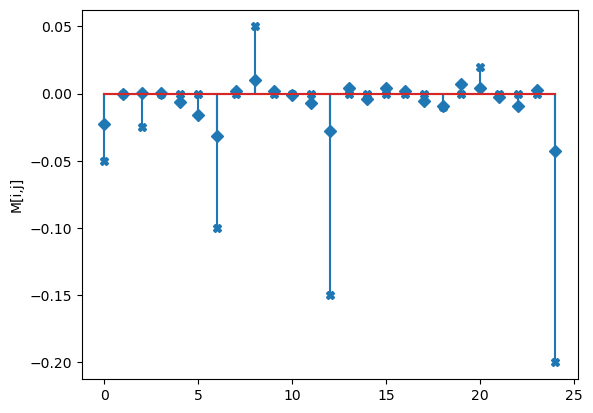

In [3]:
set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# instantiate simulator
simulator = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# data structures for results
ryobs = []
rsobs = []
ry0 = []
rs0 = []
X = np.array([], dtype=np.double).reshape(0, num_species+1)
F = np.array([], dtype=np.double).reshape(0, num_species)

num_timecourses = 3
times = np.arange(0, 5, 1)
for timecourse_idx in range(num_timecourses):
    # initial conditions
    init_species = np.random.uniform(low=10, high=50, size=num_species)
    init_metabolites = np.random.uniform(low=10, high=50, size=num_metabolites)

    yobs, sobs, sy0, mu, M, _ = simulator.simulate(
        times=times, sy0=np.hstack((init_species, init_metabolites)))

    # add some gaussian noise
    yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
    sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

    # append results
    ryobs.append(yobs)
    rsobs.append(sobs)
    ry0.append(init_species)
    rs0.append(init_metabolites)
    Xs, Fs = linearize_time_course_16S(yobs, times)
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])

print(f"X: {X.shape}")
print(f"F: {F.shape}")
print(f"n: {num_species*F.shape[0]}, p: {num_species + num_species**2}")

# PERFORM REGRESSION
# get the best lambda/alpha values on a grid via cross validation
a0, a1 = fit_alpha_Ridge1(X, F, num_species=num_species, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = do_final_fit_Ridge1(X, F, num_species, a0=a0, a1=a1)
predictor = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h)

# PLOT RESULTS
# plot comparison of simulated and predicted timeseries
for timecourse_idx in range(num_timecourses):
    yobs_h, sobs_h, _, _, _, _ = predictor.simulate(
        times=times, sy0=np.hstack((ry0[timecourse_idx], rs0[timecourse_idx])))
    plot_fit_gLV(ryobs[timecourse_idx], yobs_h,
                 rsobs[timecourse_idx], sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

# ANALYSE RESULTS
# do some bootstrapping to help with interpretation of parameters
# starred parameters are considered different to zero
do_bootstrapping(X, F, num_species, a0, a1, len(times), nboots=100)

### Five species, single time course including a perturbation

Model parameters:
Model: gMLV
num_species: 5
num_metabolites: 0
num_perturbations: 2
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
beta: None
epsilon: [ 0 -1  0 -1  0]
Using the following parameters for gMLV simulation: {'num_species': 5, 'num_metabolites': 0, 'num_perturbations': 2, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'beta': None, 'epsilon': array([ 0, -1,  0, -1,  0])}
perturbation:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
n: 245, p: 30
minimum found: a0/a1/a2/error: 1e-05 0.0001 1000

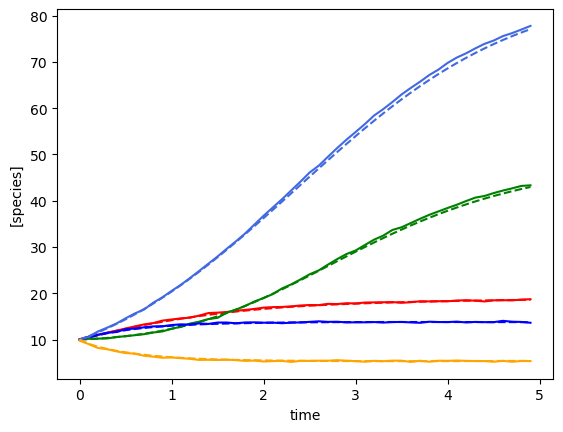

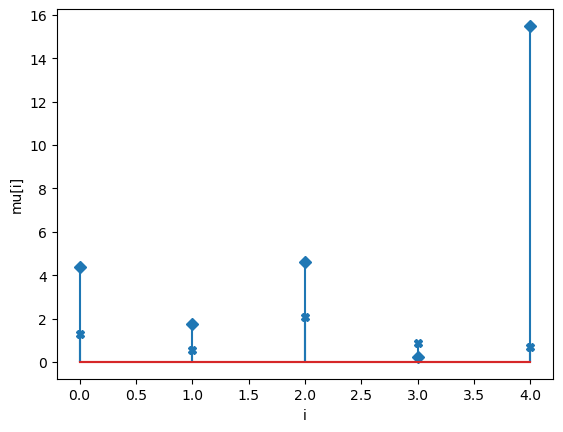

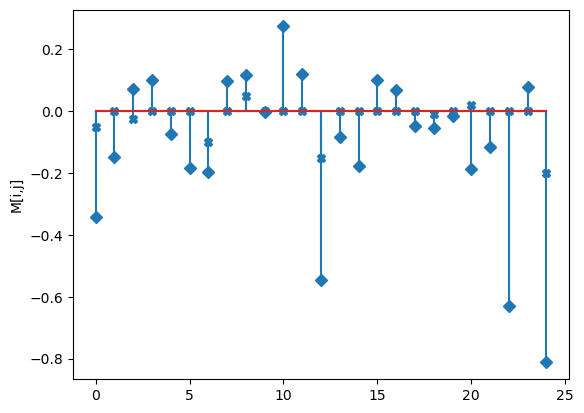

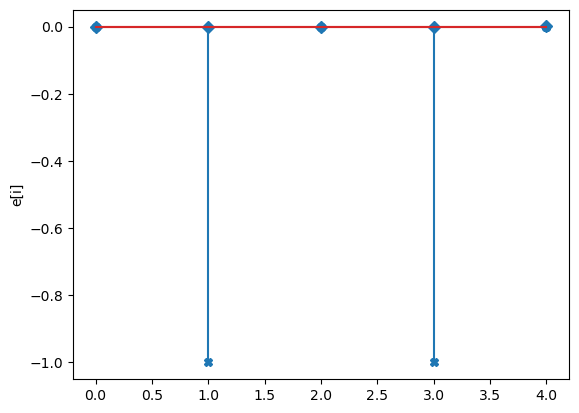

In [4]:
set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# construct perturbation matrix
epsilon = np.array([0, -1, 0, -1, 0])


# perturbation
num_perturbations = 2

# instantiate simulator
simulator = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu,
                     epsilon=epsilon,
                     num_perturbations=num_perturbations)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)


times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times,
                                               sy0=np.hstack(
                                                   (init_species, init_metabolites)))


# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
# plot_gMLV(yobs, sobs, times)

# PERFORM REGRESSION
# time dependent perturbation
u = (times >= 2) & (times < 3)
u = u.astype(int)
print('perturbation:\n', u)

# linearise
X, F = linearize_time_course_16S_u(yobs, times, u)
print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")

# get the best lambda/alpha values on a grid via cross validation
a0, a1, a2 = fit_alpha_Ridge2(
    X, F, num_species=num_species, num_pert=1, n_a0=10, n_a1=10, n_a2=10)

# do final fit
mu_h, M_h, e_h = do_final_fit_Ridge2(
    X, F, num_species=num_species, num_pert=1, a0=a0, a1=a1, a2=a2)

predictor = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h,
                     epsilon=e_h,
                     num_perturbations=num_perturbations)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times,
                                                sy0=np.hstack(
                                                    (init_species, init_metabolites)))

# PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h), e=(np.array([0, -1, 0, -1, 0]), e_h))

### Fit same data with the multi-penalty lasso

In [8]:
# F = dlnX/dt
DlnX = np.diff(np.log(yobs), axis=0)
Dt = np.tile(np.diff(times), (num_species, 1))
F = np.divide(DlnX, np.transpose(Dt))

# X matrix: stacked observed counts
mX = np.vstack([np.transpose(yobs), np.ones(len(times))])
tX = np.transpose(mX[:, :-1])

alphas = fit_alpha_MPLasso(tX, F, 10)

alpha = np.append(np.ones(num_species)*alphas[0], alphas[1])
model = MultiPenaltyLasso(alpha=alpha)
model.fit(tX, F)

mu_h = [model.coef_[i][-1] for i in range(0, num_species)]
M_h = [model.coef_[i][:num_species].tolist() for i in range(0, num_species)]

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

rho = 100

# get prediction
predictor = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h,
                     beta=rho)  # FIXME: what is rho on how to solve for this problem?
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(
    times=times, sy0=np.hstack((init_species, init_metabolites)))

# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\Documents\GitHub\MIMIC\mimic\model_infer\multi_penalty_lasso.py", line 29, in fit
    self.coef_ = self.non_zero_penalties(X, y)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\Documents\GitHub\MIMIC\mimic\model_infer\multi_penalty_lasso.py", line 52, in non_zero_penalties
    model.fit(X_p, y)
  File "c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py", line 892, in fit
    self._validate_params()
  File "c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\sklearn\utils\_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_iter' parameter of Lasso must be an int in the range [1, inf) or None. Got 1000000.0 instead.
